In [57]:
import numpy as np
import scipy
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import collections  as mc
%matplotlib inline

import glob
import os
import pickle
import datetime


if "__file__" not in dir():
    %run loadRat_documentation.ipynb
    %run plotRat_documentation_1_GeneralBehavior.ipynb


    
# INFO: all the default parameters for preprocessing
defaultParam={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }

### Load Data
Load the preprocess data (corrected and binned position, speed, median position, ...)
 DEFAULT: load pickle if they exist, or create them
data=Data(root,animal,experiment,param=param)

 OPTION 1: do not save any new pickle file
data=Data(root,animal,experiment,param,saveAsPickle=False)

 OPTION 2: redo the preprocessing with param, even if the pickle already exist
 (to be sure everything is preprocess with the same parameters)

In [45]:
#run only if inside this notebook (do not execute if "%run this_notebook")
if "__file__" not in dir():
    root="/data"
    animal="Rat041"
    experiment="Rat041_2015_08_17_10_34"
    param={
        "goalTime":7,
        "treadmillRange":[0,90],
        "maxTrialDuration":20,
        "interTrialDuration":10,
        "endTrial_frontPos":30,
        "endTrial_backPos":55, 
        "endTrial_minTimeSec":4,
        "binSize":0.25,
    }  
    data=Data(root,animal,experiment,param,redoPreprocess=True)
    print(data.hasBehavior)
    #print(data.dataType)
    #print(data.treadmillSpeed)
    print(data.experiment)
    print(data.cameraSamplingRate)

Preprocessing behavior data...
Behavior data loaded from text files: new setup (.behav_param)
trial 16: only 0 unique positions, skip
trial 17: only 0 unique positions, skip
trial 18: only 0 unique positions, skip
trial 19: only 0 unique positions, skip
trial 20: only 0 unique positions, skip
trial 21: only 0 unique positions, skip
trial 22: only 0 unique positions, skip
trial 23: only 0 unique positions, skip
trial 24: only 0 unique positions, skip
trial 25: only 0 unique positions, skip
trial 26: only 0 unique positions, skip
trial 27: only 0 unique positions, skip
Preprocessing done
No spike data
True
Rat041_2015_08_17_10_34
25.0


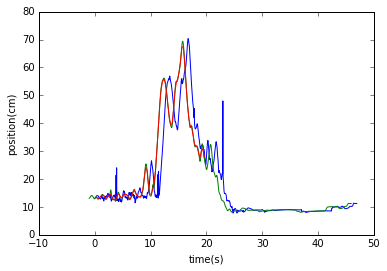

In [46]:
#run only if inside this notebook (do not execute if "%run this_notebook")
if "__file__" not in dir():
    plt.plot(data.rawTime[5],data.rawPosition[5])
    #plt.plot(data.timeTreadmill[5],data.rawPosition[5])
    plt.plot(data.timeTreadmill[5],data.position[5])
    plt.plot(data.timeBin,data.positionBin[5])#centered
    plt.ylabel("position(cm)")
    plt.xlabel("time(s)")

### Display all attributes and their type  
Every attributes can be access with `data.attributeName`  

In [47]:
#run only if inside this notebook (do not execute if "%run this_notebook")
if "__file__" not in dir():
    data.describe()
    print(data.emptyAnalysisFiles)

Session: Rat041_2015_08_17_10_34
Full Path: /data/Rat041/Experiments/Rat041_2015_08_17_10_34/Rat041_2015_08_17_10_34
Number of trials: 28
---------------------------------------------------------------------------------------------
**Name**                     **Type**   **Content**                    **Extract**                   
---------------------------------------------------------------------------------------------
accelerationOnSpeedBin       dict       nKeys=16                       keys: [0, 1, 2, 3, 4, 5, 6,...
accelerationOnSpeedSmoothBin dict       nKeys=16                       keys: [0, 1, 2, 3, 4, 5, 6,...
analysisPath                 str        /data/Rat041/Experiments/Rat041_2015_08_17_10_34/Analysis                               
animal                       str        Rat041                                                       
binSize                      float      0.25                                                         
cameraSamplingRate           float 

# Speed investigation

0.531535343386


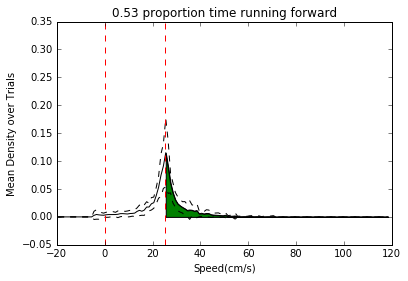

In [48]:
def plot_proportionTimeRunningForward_TrajEnd(data,binSize=1,minSpeed=-20,maxSpeed=120,smoothSpeed=0.3,onlyGood=False,highSpeed=None):
    '''
    Position aligned on detected end
    Speed= treadmill speed - difference(position) * camera sampling rate
    Histograms are computed trial by trial then averaged
    Plot histogram of speeds
    Returns the cumulative of high speed occurencies (speed > treadmillspeed *2 )
    '''
    bins = np.arange(minSpeed,maxSpeed,binSize)
    if onlyGood==True:
        Hist = np.zeros((len(data.goodTrials),len(bins)-1))
    else:        
        Hist = np.zeros((len(data.trials),len(bins)-1))
    k = 0
    for trial in data.trials:
        if (not onlyGood) or (trial in data.goodTrials):
            s,t=get_speed_treadmillON(data,trial,sigmaSpeed=smoothSpeed)
            n,_= np.histogram(s,bins,density=True)   
            Hist[k,:] = n
            k+=1
    avgHist = np.mean(Hist,axis=0)
    stdHist = np.std(Hist,axis=0)
    #check that the vector is not empty
    if np.sum(avgHist)==0:
        return np.nan   
    centers=(bins[:-1]+bins[1:])/2.0
    
    #area under curve
    if highSpeed==None:
        treadmillSpeed = np.nanmean(data.treadmillSpeed)
    indexList = np.where(centers > (treadmillSpeed))[0]
    index = indexList[0] #first index where speed = treadmillspeed
    areaUnderCurve =  np.sum(avgHist[index:]) * binSize
    #print (areaUnderCurve)
    #plot
    plt.plot(centers,avgHist,"k-")
    plt.plot(centers,avgHist+stdHist,"k--")
    plt.plot(centers,avgHist-stdHist,"k--")
    plt.axvline(0,color="r",ls="--")
    plt.axvline(treadmillSpeed, color="r",ls="--")
    plt.ylim([-0.05,0.35])
    plt.ylabel("Mean Density over Trials")
    plt.xlabel("Speed(cm/s)")
    plt.fill_between(centers[index:],0*avgHist[index:], avgHist[index:], facecolor='green', interpolate=True)
    title="%.2f proportion time running forward"%(areaUnderCurve)
    if onlyGood:
        title+=" - %s good trials"%(len(data.goodTrials))
    plt.title(title)
    return areaUnderCurve 

#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    plot_proportionTimeRunningForward_TrajEnd(data,binSize=1,smoothSpeed=0.3, onlyGood=False)
    #save figure
    #path=os.path.join(root,"Analysis")
    #pathFig=os.path.join(path,"Borrar_Rat081_last_time.svg")
    #plt.savefig(pathFig,format="svg")


25.0
30.7392997935


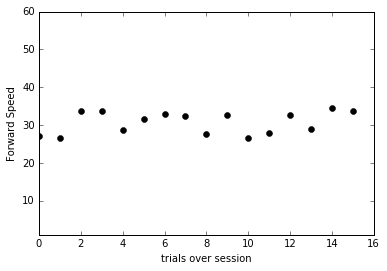

In [49]:
def plot_mean_forwardSpeed(data,smoothSpeed=0.3, onlyGood=True):
    '''
    plot mean forwardSpeed 
    '''
    ValuesSessionRatio=[]
    treadmillSpeed = np.nanmean(data.treadmillSpeed)
    #print(treadmillSpeed)
    for trial in data.trials:
        if (not onlyGood) or (trial in data.goodTrials):
            speed,time=get_speed_treadmillON(data,trial,sigmaSpeed=smoothSpeed)
            MeanSpeed=np.nanmean(speed[speed>treadmillSpeed])
            ValuesSessionRatio.append(MeanSpeed)

    SessionRatio=np.nanmean(ValuesSessionRatio)
    #print(SessionRatio)
    #plot
    plt.plot(ValuesSessionRatio,"ko")
    plt.ylabel("Forward Speed")
    plt.xlabel("trials over session")
    plt.ylim([1,60])
    
    
    return SessionRatio

#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    x = plot_mean_forwardSpeed(data,smoothSpeed=0.3,onlyGood=False)
    #plt.close()

25.0
1.22957199174


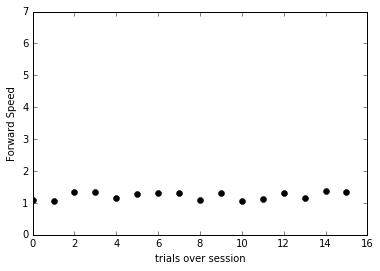

In [50]:
def plot_mean_forwardSpeedVsTreadmillSpeed(data,smoothSpeed=0.3, onlyGood=True):
    '''
    plot mean forwardSpeed related to treadmill speed
    '''
    ValuesSessionRatio=[]
    treadmillSpeed = np.nanmean(data.treadmillSpeed)
    #print(treadmillSpeed)
    for trial in data.trials:
        if (not onlyGood) or (trial in data.goodTrials):
            speed,time=get_speed_treadmillON(data,trial,sigmaSpeed=smoothSpeed)
            MeanSpeed=np.nanmean(speed[speed>treadmillSpeed])
            ratio=MeanSpeed/treadmillSpeed
            ValuesSessionRatio.append(ratio)

    SessionRatio=np.nanmean(ValuesSessionRatio)
    #print(SessionRatio)
    #plot
    plt.plot(ValuesSessionRatio,"ko")
    plt.ylabel("Forward Speed Vs TreadmillSpeed")
    plt.xlabel("trials over session")
    plt.ylim([0,7])
    
    
    return SessionRatio

#----------------------------------------------------------------------------------------------------------------------
if "__file__" not in dir():
    x = plot_mean_forwardSpeedVsTreadmillSpeed(data,smoothSpeed=0.3,onlyGood=False)
    #plt.close()

9.41063462184
18.1501737673


/home/david/miniconda/lib/python3.4/site-packages/ipykernel/__main__.py:32: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/david/miniconda/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


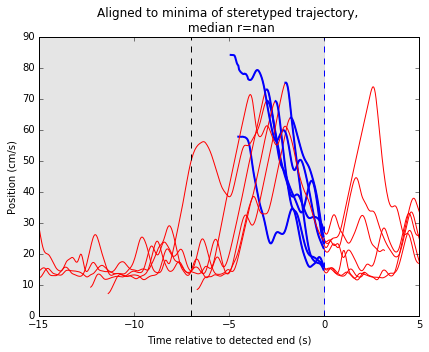

In [56]:
def plot_Tortuosity(data, onlyGood=True):
    
    
    cs=data.cameraSamplingRate
    ValuesSessionTortuosity=[]
    ValuesSessionStraightSpeed=[]
    

    for trial in data.position:
        end=data.timeEndTrial[trial]
        stop=data.stopFrame[trial]
        start=data.startFrame[trial]#+data.cameraToTreadmillDelay*data.cameraSamplingRate
        indexStart=np.argmax(data.position[trial])
        indexEnd=data.indexEndTrial[trial]
        if isNone(end):
            continue
        PositionStart=data.position[trial][indexStart] 
        PositionEnd=data.position[trial][indexEnd]
        PositionPath=data.position[trial][indexStart:indexEnd]
        RunDistance=np.sum(np.abs(data.treadmillSpeed[trial]*data.binSize-np.diff(PositionPath)))
        straightDistance=np.abs(PositionStart-PositionEnd)
        tortuosity=RunDistance/straightDistance
        straightSpeed=np.abs(straightDistance/((indexStart-indexEnd)/cs))
        #if trial==1:
            #print(straightDistance)
            #print(indexStart)
            #print(indexEnd)
            #plt.plot(data.position[trial][indexStart:indexEnd])
        ValuesSessionTortuosity.append(tortuosity)
        ValuesSessionStraightSpeed.append(straightSpeed)
        
    SessionTortuosity=np.nanmean(ValuesSessionTortuosity)
    SessionStraightSpeed=np.nanmean(ValuesSessionStraightSpeed)
    #print(SessionTortuosity)
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(121)
    plt.plot(ValuesSessionTortuosity,"ko")
    plt.ylabel("Tortuosity")
    plt.xlabel("trials over session")
    plt.ylim([0,10])
    
    #print(SessionStraightSpeed)
    #plot
    plt.subplot(122)
    plt.plot(ValuesSessionStraightSpeed,"ko")
    plt.ylabel("Straight Speed (cm/sec)")
    plt.xlabel("trials over session")
    plt.ylim([0,50])
    return SessionTortuosity,SessionStraightSpeed

#----------------------------------------------------------------------------------------------------------------------

if "__file__" not in dir():
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    #plot_position_align_end(data,onlyGood=False)
    plot_position_align_end_StereotypedTrials(data,onlyGood=False)
    
    x = plot_Tortuosity(data,onlyGood=False)
    
    #plt.xlim([0,25]),plt.ylim([0,25])
